<a href="https://colab.research.google.com/github/plaban1981/Huggingface_transformers_course/blob/main/Machinehack_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

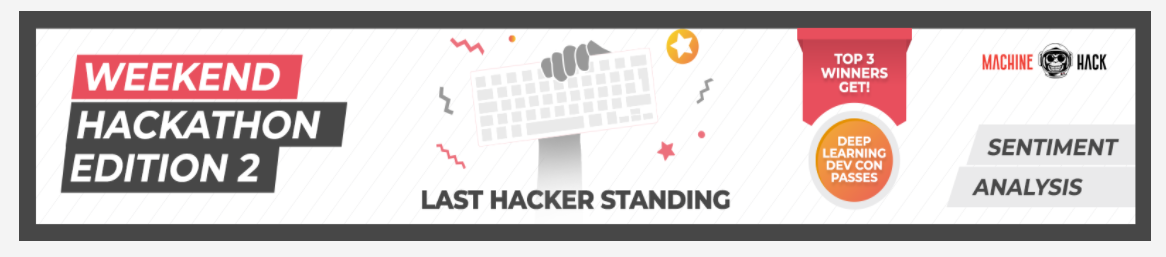

In [1]:
from google.colab import files
files.upload()

Saving Data_SAWE_2_LHS.zip to Data_SAWE_2_LHS.zip


## Unzip Training Data

In [2]:
%%capture
!unzip "/content/Data_SAWE_2_LHS.zip" 

## Read training and test data

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [7]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sub = pd.read_csv("/content/submission.csv")

In [3]:
train.head()

,ID,author,Review,Sentiment
0,39467,rayinstirling,Today I'm working on my &quot;Quirky Q&quot; c...,2
1,30154,DirtyRose17,@ShannonElizab dont ya know? people love the h...,1
2,16767,yoliemichelle,ughhh rejected from the 09 mediation program. ...,0
3,9334,jayamelwani,@petewentz im so jealous. i want an octo drive,0
4,61178,aliisanoun,I remember all the hype around this movie when...,0


In [5]:
test.head()

,ID,author,Review
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe..."
4,34410,phaoloo,@dharshana anytime


In [6]:
test['Sentiment'] = 0

In [8]:
sub.head()

,Negative_0,Neutral_1,Positive_2
0,0,1,0
1,1,0,0
2,0,0,1
3,0,0,0
4,0,0,0


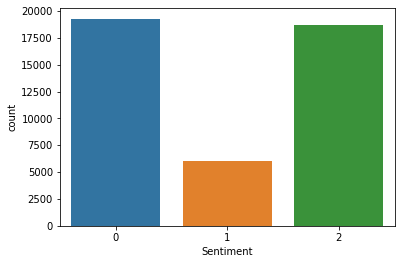

In [9]:
sns.countplot(x ='Sentiment',data= train)

## Extract Features and Labels

In [8]:
train_texts = train['Review'].values.tolist()
train_labels = train['Sentiment'].values.tolist()
test_texts = test['Review'].values.tolist()


## Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2,random_state=42,stratify=train_labels)

## Install Transformers

https://huggingface.co/transformers/training.html

In [7]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 14.5 MB/s 
     |████████████████████████████████| 636 kB 71.0 MB/s 
     |████████████████████████████████| 3.3 MB 65.1 MB/s 
     |████████████████████████████████| 895 kB 73.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Fine Tuning Custom models
* Prepare dataset
* Load pretrained tokenizer, call it with dataset
* Build Pytorch datasets with encodings
* Load pretrained Model
* Load Trainer and train it OR
use native Pytorch training Pipeline

## Import required transformer libraries

In [8]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification
from transformers import Trainer,TrainingArguments

## Set Model Name

In [3]:
model_name  = 'distilbert-base-uncased'

## Tokenization

In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=3)

In [11]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True,return_tensors = 'pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True,return_tensors = 'pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')

* We can simply pass our texts to the tokenizer. We’ll pass truncation=True and padding=True, which will ensure that all of our sequences are padded to the same length and are truncated to be no longer model’s maximum input length

* This will allow us to feed batches of sequences into the model at the same time.

## Turn our labels and encodings into a Dataset object.
* In PyTorch, this is done by subclassing a torch.utils.data.Dataset object and implementing len and getitem.

In [12]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [27]:
class SentimentTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item
    def __len__(self):
        return len(self.encodings)

## Genearte DataLoaders

In [14]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentTestDataset(test_encodings)

In [15]:
train_dataset.__getitem__(0)['input_ids'].shape

torch.Size([512])

In [16]:
val_dataset.__getitem__(0)['input_ids'].shape

torch.Size([512])

In [17]:
test_dataset.__getitem__(0)['input_ids'].shape

torch.Size([512])

## Fine-tuning with Trainer

In [18]:
training_args = TrainingArguments(
    output_dir='./results1',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs1',            # directory for storing logs
    logging_steps=10,
)

In [19]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Step,Training Loss
10,1.094100
20,1.074300
30,1.072100
40,1.066200
50,1.054700
60,1.026100
70,1.019100
80,1.026300
90,0.963200
100,1.004000


Saving model checkpoint to ./results1/checkpoint-500
Configuration saved in ./results1/checkpoint-500/config.json
Model weights saved in ./results1/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-1000
Configuration saved in ./results1/checkpoint-1000/config.json
Model weights saved in ./results1/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-1500
Configuration saved in ./results1/checkpoint-1500/config.json
Model weights saved in ./results1/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-2000
Configuration saved in ./results1/checkpoint-2000/config.json
Model weights saved in ./results1/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-2500
Configuration saved in ./results1/checkpoint-2500/config.json
Model weights saved in ./results1/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results1/checkpoint-3000
Configuration saved in ./resu

TrainOutput(global_step=6615, training_loss=0.518616083906351, metrics={'train_runtime': 1695.0073, 'train_samples_per_second': 62.442, 'train_steps_per_second': 3.903, 'total_flos': 1.402059950678016e+16, 'train_loss': 0.518616083906351, 'epoch': 3.0})

## Make predictions on TEST DATA

In [39]:
test.shape

(18900, 4)

In [47]:
test['Sentiment'] = 0
test_texts = test['Review'].values.tolist()
test_labels = test['Sentiment'].values.tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True,return_tensors = 'pt')
test_dataset = SentimentDataset(test_encodings, test_labels)

In [48]:
len(test_dataset)

18900

In [30]:
test_dataset[0]['input_ids'].__len__()

512

In [49]:
preds = trainer.predict(test_dataset=test_dataset)

***** Running Prediction *****
  Num examples = 18900
  Batch size = 64


In [50]:
preds[0]

array([[-1.3265194 , -2.0514555 ,  2.7144065 ],
       [ 0.16520119,  0.6533342 , -1.0126475 ],
       [ 4.62348   , -3.2592976 , -1.843316  ],
       ...,
       [ 2.7889578 , -1.0650877 , -2.08205   ],
       [-0.30165145,  0.14190683,  0.16596912],
       [-0.7264257 ,  1.4411033 , -0.70946777]], dtype=float32)

In [51]:
predictions = preds[0].tolist()

In [52]:
predictions = np.argmax(preds[0],axis=1).tolist()

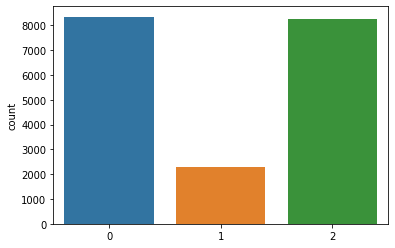

In [53]:
import seaborn as sns
sns.countplot(predictions)

In [54]:
test['Sentiment'] = predictions

In [55]:
test.head()

,ID,author,Review,Sentiment
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...,2
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...,1
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...,0
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe...",2
4,34410,phaoloo,@dharshana anytime,1


In [56]:
sub.head()

,Negative_0,Neutral_1,Positive_2
0,0,1,0
1,1,0,0
2,0,0,1
3,0,0,0
4,0,0,0


##Defining function to format prediction labels as required for submission

In [57]:
def labels(x):
  if x == 0:
    return 'Negative_0'
  elif x == 1:
    return 'Neutral_1'
  else:
    return 'Positive_2'
test['Sentiment'] = test['Sentiment'].map(labels)
test.head()

,ID,author,Review,Sentiment
0,29536,nathantbaker,@amyswarren ahhh yay! I'm getting into it. Kno...,Positive_2
1,13442,Umatter2Chtr,@DeliverImHungry You are right. If you ordere...,Neutral_1
2,54697,bella_cullen_4,I'd heard a lot of bad things about this film ...,Negative_0
3,7007,marviemorales,"I miss the old... HA, HA. I can't tell that pe...",Positive_2
4,34410,phaoloo,@dharshana anytime,Neutral_1


In [58]:
df = pd.get_dummies(test['Sentiment'])

In [60]:
df.head()

,Negative_0,Neutral_1,Positive_2
0,0,0,1
1,0,1,0
2,1,0,0
3,0,0,1
4,0,1,0


In [61]:
df.to_csv("distilbert.csv",index=False)

In [ ]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis',model=model_name)
result = classifier(test_texts)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed

## Processing using TextHero